<a href="https://colab.research.google.com/github/tiaracantiq/gitgithub/blob/main/Implementation_of_Support_Vector_Machine_Algorithm_with_Recursive_Feature_Elimination_Method_for_Predicting_Arrhythmia_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 64.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:
import pandas as pd

# baca file CSV dengan delimiter titik-koma
df = pd.read_csv('/content/drive/MyDrive/Skripsi/Dataset/Penyakit_Jantung/data_aritmia.csv', sep=';')

# tampilkan ukuran dataset dan 5 baris awal
print(df.shape)
df.head()


(452, 280)


,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


In [15]:
df = df.copy()  # Membuat salinan DataFrame agar data asli tidak berubah
df = df.replace(['?', ' ', ''], np.nan)  # Mengganti ?, spasi kosong, dan string kosong menjadi NaN

# Mengubah semua kolom kecuali 'diagnosis' menjadi numerik, yang error akan diubah jadi NaN
for col in df.columns:
    if col != 'diagnosis':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Menghapus kolom yang seluruh isinya NaN
na_all = df.columns[df.isna().all()]
df = df.drop(columns=na_all)

# Mengisi nilai NaN pada kolom numerik (selain diagnosis) dengan median kolom tersebut
for col in df.columns:
    if col != 'diagnosis' and df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Membuat kolom target biner: jika diagnosis != 1 maka 1, jika diagnosis == 1 maka 0
df['target'] = (df['diagnosis'] != 1).astype(int)

# Memisahkan fitur (X) dan label (y)
X = df.drop(columns=['diagnosis', 'target'])
y = df['target']

# Menampilkan jumlah fitur dan distribusi label target
print("Jumlah fitur:", X.shape[1])
y.value_counts()


Jumlah fitur: 279


,count
target,
0,245
1,207


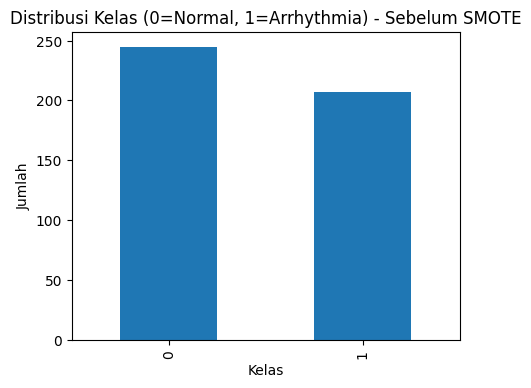

In [18]:
fig, ax = plt.subplots(figsize=(5,4))  # Membuat area plot (figure dan axis) dengan ukuran 5x4 inci
y.value_counts().sort_index().plot(kind='bar', ax=ax)  # Hitung jumlah data tiap kelas, urutkan berdasarkan index (0 dan 1), lalu tampilkan dalam bentuk grafik batang
ax.set_title("Distribusi Kelas (0=Normal, 1=Arrhythmia) - Sebelum SMOTE")  # Judul grafik
ax.set_xlabel("Kelas")  # Label sumbu X (kelas 0 dan 1)
ax.set_ylabel("Jumlah")  # Label sumbu Y (jumlah data tiap kelas)
plt.show()  # Menampilkan grafik


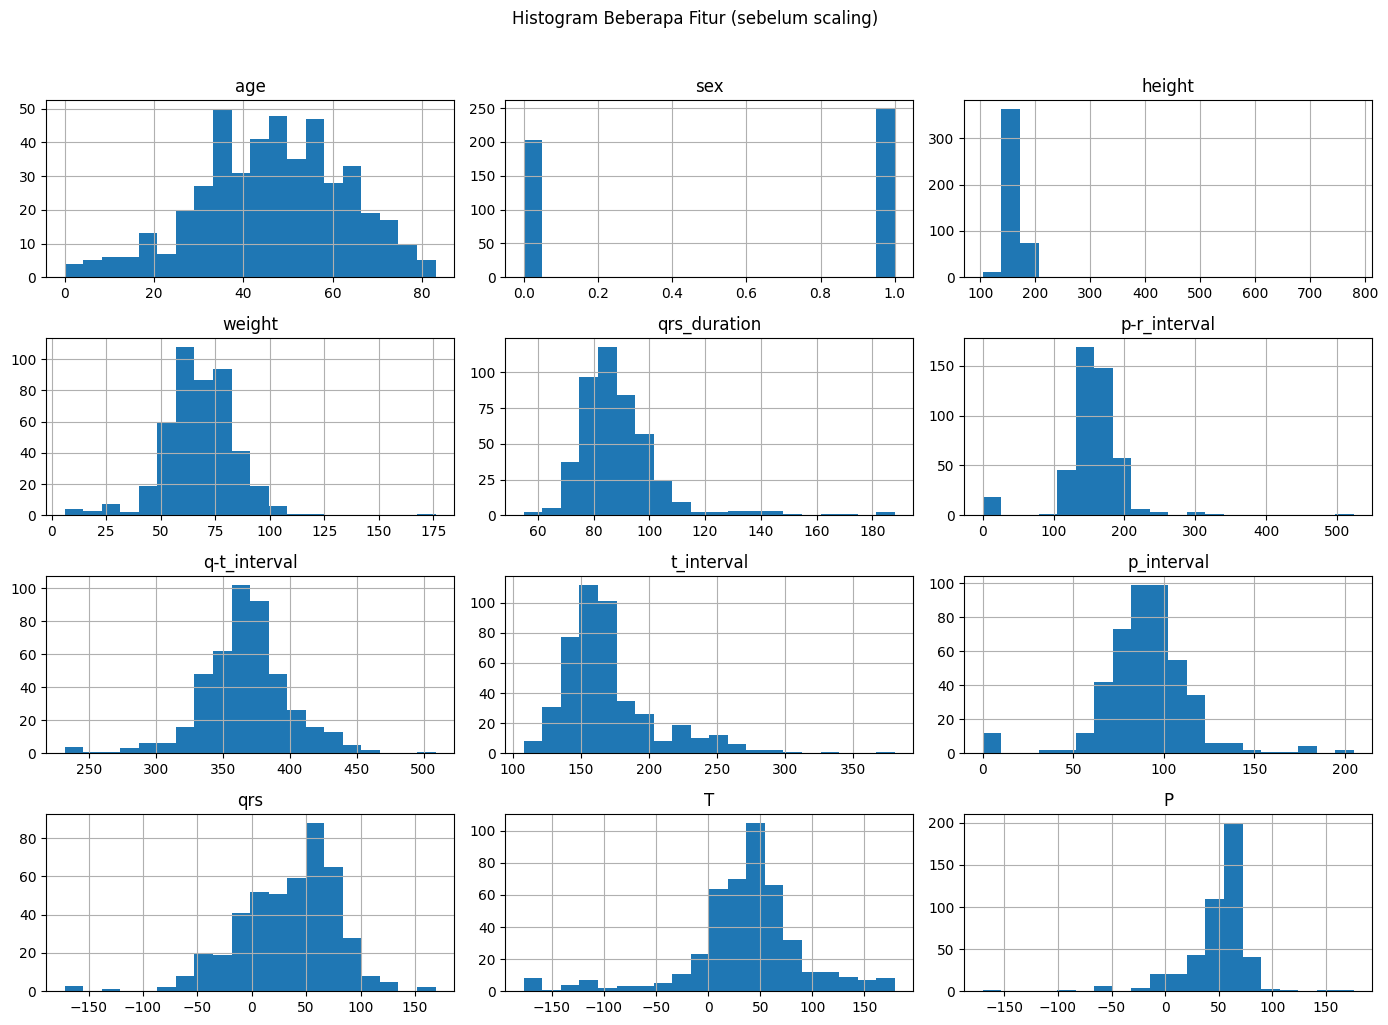

In [19]:
sample_cols = X.columns[:12]  # Ambil 12 kolom pertama dari fitur X untuk dijadikan sampel visualisasi
X[sample_cols].hist(figsize=(14,10), bins=20)  # Buat histogram untuk setiap kolom sampel, ukuran gambar 14x10 inci, jumlah bin 20
plt.suptitle("Histogram Beberapa Fitur (sebelum scaling)", y=1.02)  # Judul utama untuk keseluruhan histogram
plt.tight_layout()  # Atur tata letak agar grafik tidak saling tumpang tindih
plt.show()  # Tampilkan semua histogram


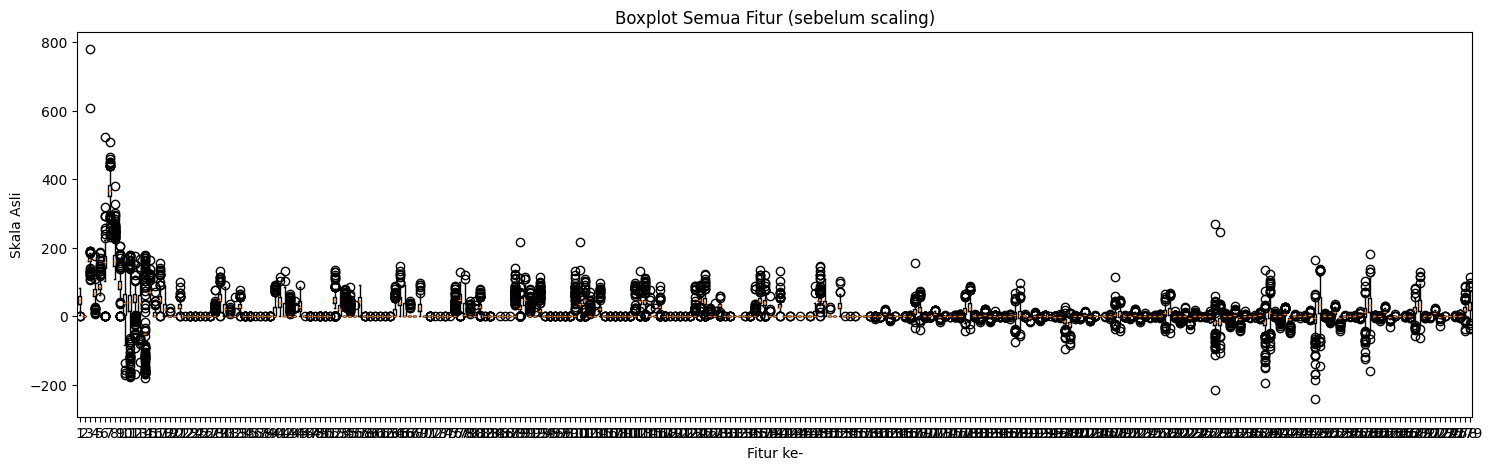

In [20]:
plt.figure(figsize=(18,5))  # Membuat canvas gambar berukuran 18x5 inci
plt.boxplot(X.values, showfliers=True)  # Membuat boxplot untuk semua fitur X, dengan menampilkan outlier (titik ekstrem)
plt.title("Boxplot Semua Fitur (sebelum scaling)")  # Judul plot
plt.xlabel("Fitur ke-")  # Label sumbu X mewakili urutan fitur
plt.ylabel("Skala Asli")  # Label sumbu Y menunjukkan skala nilai asli tiap fitur
plt.show()  # Menampilkan plot


/tmp/ipython-input-186943121.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(before_smote.keys()), y=list(before_smote.values()), ax=axes[0], palette="Blues_d")
/tmp/ipython-input-186943121.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(after_smote.keys()), y=list(after_smote.values()), ax=axes[1], palette="Greens_d")


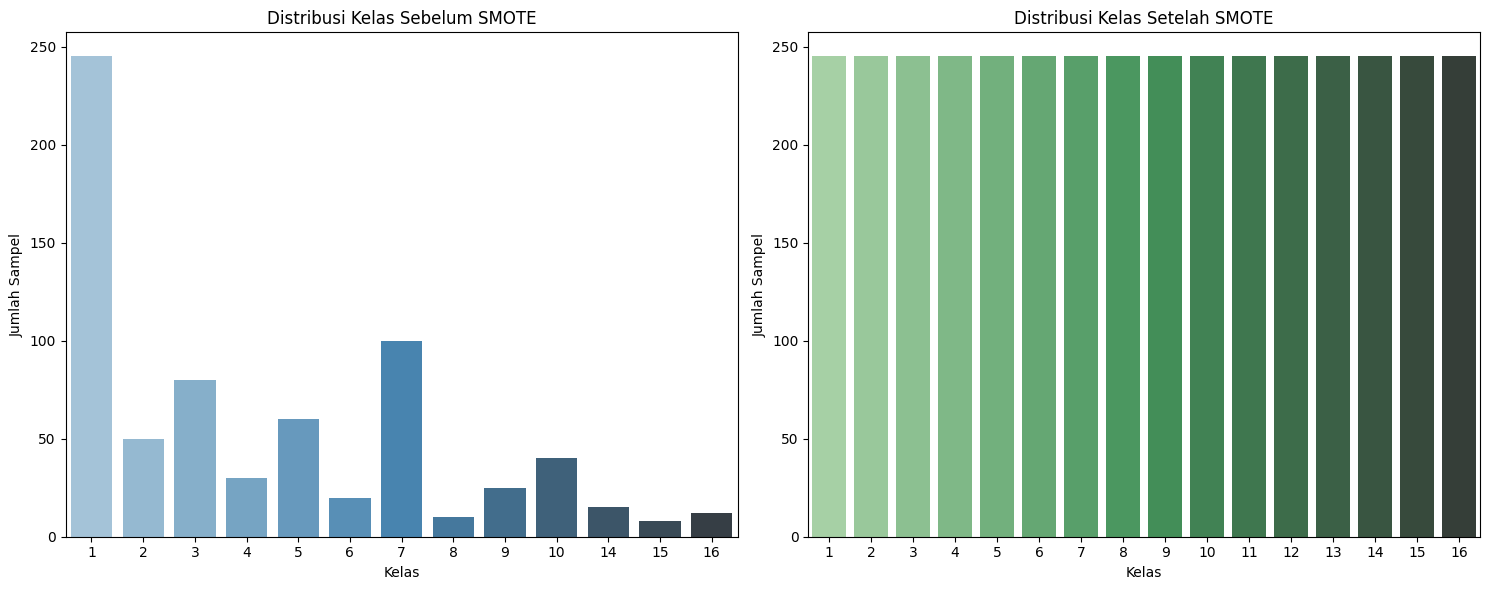

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Jumlah sampel untuk setiap kelas sebelum SMOTE (tidak seimbang)
before_smote = {
    1: 245, 2: 50, 3: 80, 4: 30, 5: 60, 6: 20,
    7: 100, 8: 10, 9: 25, 10: 40, 14: 15, 15: 8, 16: 12
}

# Jumlah sampel setelah SMOTE (semua kelas disamakan ke 245)
after_smote = {cls: 245 for cls in range(1, 17)}

# Buat dua subplot dalam satu baris (kiri: sebelum, kanan: sesudah)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot distribusi kelas sebelum SMOTE
sns.barplot(x=list(before_smote.keys()), y=list(before_smote.values()), ax=axes[0], palette="Blues_d")
axes[0].set_title("Distribusi Kelas Sebelum SMOTE")
axes[0].set_xlabel("Kelas")
axes[0].set_ylabel("Jumlah Sampel")

# Plot distribusi kelas setelah SMOTE
sns.barplot(x=list(after_smote.keys()), y=list(after_smote.values()), ax=axes[1], palette="Greens_d")
axes[1].set_title("Distribusi Kelas Setelah SMOTE")
axes[1].set_xlabel("Kelas")
axes[1].set_ylabel("Jumlah Sampel")

# Atur layout agar tidak tumpang tindih dan tampilkan grafik
plt.tight_layout()
plt.show()


In [22]:
def pick_safe_k_neighbors(y_train, base_k=5):
    """k_neighbors = min(base_k, min_count-1) agar SMOTE tidak error."""
    vc = pd.Series(y_train).value_counts()  # Menghitung jumlah data di setiap kelas target
    min_count = vc.min()  # Menemukan jumlah data paling sedikit (kelas minoritas)
    return max(1, min(base_k, min_count - 1))  # Menentukan k_neighbors aman:
                                               # - minimal 1
                                               # - maksimal base_k
                                               # - tidak melebihi (min_count - 1)


In [23]:
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE

# Pisahkan fitur dan target
target_col = df.columns[-1]  # Ambil kolom terakhir sebagai target
X = df.drop(columns=[target_col])  # Semua kolom kecuali target jadi fitur
y = df[target_col]  # Kolom target

print("Distribusi kelas sebelum SMOTE:", Counter(y))  # Hitung dan tampilkan distribusi kelas awal

# Cari kelas dengan jumlah sampel paling sedikit
minority_class = min(Counter(y), key=Counter(y).get)  # Ambil kelas minoritas
minority_count = Counter(y)[minority_class]  # Jumlah data kelas minoritas

# Hitung range k_neighbors yang memungkinkan
max_k = max(1, minority_count - 1)
print(f"Range k_neighbors yang mungkin: 1 sampai {max_k}\n")

# Coba beberapa nilai k_neighbors
for k in [1, 3, 5]:
    if k < minority_count:  # Pastikan k lebih kecil dari jumlah kelas minoritas
        smote = SMOTE(k_neighbors=k, random_state=42)  # Inisialisasi SMOTE dengan k tertentu
        X_res, y_res = smote.fit_resample(X, y)  # Lakukan oversampling
        print(f"Distribusi kelas setelah SMOTE (k={k}):", Counter(y_res))  # Tampilkan distribusi kelas hasil SMOTE


Distribusi kelas sebelum SMOTE: Counter({0: 245, 1: 207})
Range k_neighbors yang mungkin: 1 sampai 206

Distribusi kelas setelah SMOTE (k=1): Counter({1: 245, 0: 245})
Distribusi kelas setelah SMOTE (k=3): Counter({1: 245, 0: 245})
Distribusi kelas setelah SMOTE (k=5): Counter({1: 245, 0: 245})


/tmp/ipython-input-3737644154.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(before.keys()), y=list(before.values()), ax=axes[0], palette="Reds_d")
/tmp/ipython-input-3737644154.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(dist.keys()), y=list(dist.values()), ax=axes[i], palette="Blues_d")
/tmp/ipython-input-3737644154.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(dist.keys()), y=list(dist.values()), ax=axes[i], palette="Blues_d")
/tmp/ipython-input-3737644154.py:41: FutureWarning: 

Passing `palette

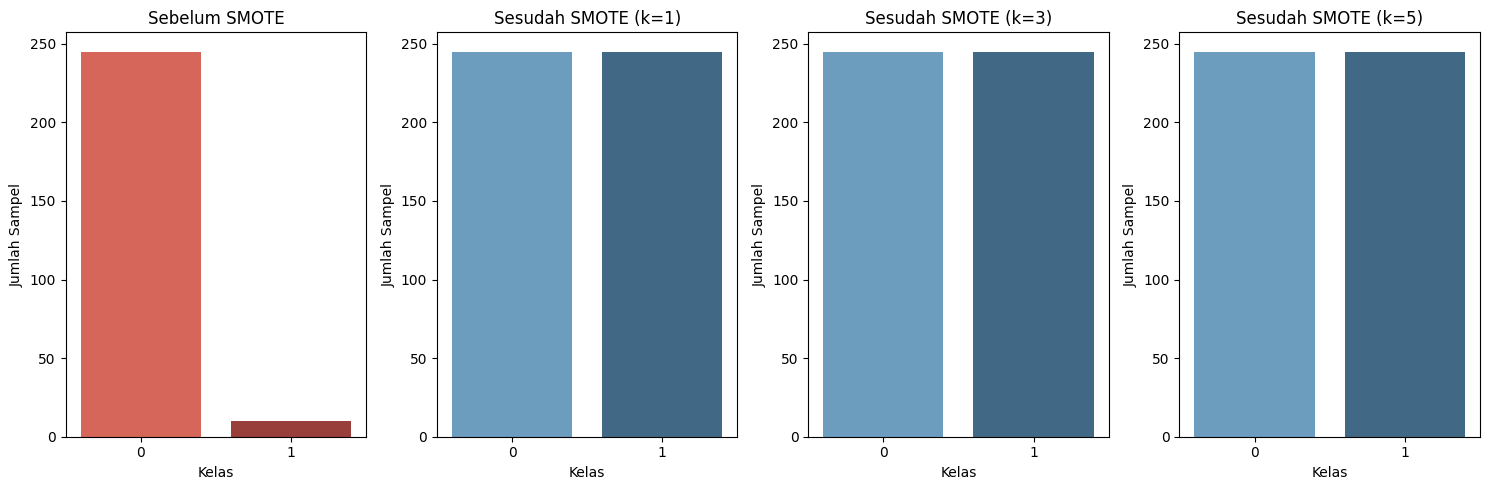

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
import pandas as pd

# Contoh dataset tidak seimbang (dummy)
df = pd.DataFrame({
    'f1': range(255),
    'f2': range(100, 355),
    'target': [0]*245 + [1]*10  # mayoritas=0, minoritas=1
})

# Pisahkan fitur dan target
target_col = df.columns[-1]
X = df.drop(columns=[target_col])
y = df[target_col]

# Distribusi sebelum SMOTE
before = Counter(y)

# Simpan hasil sesudah SMOTE untuk k=1,3,5
results = {}
for k in [1, 3, 5]:
    if k < min(before.values()):  # hanya kalau k valid
        smote = SMOTE(k_neighbors=k, random_state=42)
        X_res, y_res = smote.fit_resample(X, y)
        results[k] = Counter(y_res)

# Visualisasi
fig, axes = plt.subplots(1, len(results)+1, figsize=(15,5))

# Plot sebelum SMOTE
sns.barplot(x=list(before.keys()), y=list(before.values()), ax=axes[0], palette="Reds_d")
axes[0].set_title("Sebelum SMOTE")
axes[0].set_xlabel("Kelas")
axes[0].set_ylabel("Jumlah Sampel")

# Plot sesudah SMOTE
for i, (k, dist) in enumerate(results.items(), start=1):
    sns.barplot(x=list(dist.keys()), y=list(dist.values()), ax=axes[i], palette="Blues_d")
    axes[i].set_title(f"Sesudah SMOTE (k={k})")
    axes[i].set_xlabel("Kelas")
    axes[i].set_ylabel("Jumlah Sampel")

plt.tight_layout()
plt.show()


In [25]:
import seaborn as sns

def plot_cm_2x2(y_true, y_pred, title="Confusion Matrix", cmap="Blues", annot_color='white'):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])  # Hitung confusion matrix untuk kelas 0 dan 1
    plt.figure(figsize=(5,4))  # Ukuran plot 5x4 inci
    ax = sns.heatmap(
        cm, annot=True, fmt='d', cmap=cmap, cbar=True,  # Tampilkan nilai tiap sel (annot=True)
        xticklabels=[0,1], yticklabels=[0,1], vmin=0    # Label sumbu X dan Y sesuai kelas 0 & 1
    )
    ax.set_xlabel("Predicted")  # Label sumbu X = hasil prediksi
    ax.set_ylabel("True")       # Label sumbu Y = label sebenarnya
    ax.set_title(title)         # Judul plot
    plt.yticks(rotation=0)      # Biar label sumbu Y tidak miring
    plt.show()                  # Tampilkan plot
    return cm                   # Kembalikan confusion matrix sebagai output


In [26]:
def eval_scores(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),                # Akurasi: proporsi prediksi yang benar dari seluruh data
        "precision": precision_score(y_true, y_pred, zero_division=0),  # Presisi: seberapa banyak prediksi positif yang benar
        "recall": recall_score(y_true, y_pred, zero_division=0),        # Recall: seberapa banyak kasus positif yang berhasil terdeteksi
        "f1": f1_score(y_true, y_pred, zero_division=0),                # F1 Score: rata-rata harmonik dari presisi dan recall
    }


RFE

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# ==============================
# 1. Plot Confusion Matrix
# ==============================
def plot_cm_2x2(y_true, y_pred, title="Confusion Matrix", cmap="Blues", annot_color='white'):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=True,
                     xticklabels=[0, 1], yticklabels=[0, 1], vmin=0)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.yticks(rotation=0)
    plt.show()
    return cm

# ==============================
# 2. Evaluation Scores
# ==============================
def eval_scores(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

# ==============================
# 3. Feature Selection with RFE + LinearSVC
# ==============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Pastikan variabel X dan y sudah didefinisikan sebelumnya

svc = LinearSVC(max_iter=20000, dual=False, random_state=42)

rfe = RFE(estimator=svc, n_features_to_select=10)
rfe.fit(X_scaled, y)

selected_features = X.columns[rfe.support_]
print("Jumlah fitur terpilih:", len(selected_features))
print("Fitur terpilih:", list(selected_features))


Jumlah fitur terpilih: 2
Fitur terpilih: ['f1', 'f2']


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=2. There will be no feature selection and all features will be kept.
  warnings.warn(


In [31]:
# === 0. Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === 1. Import library ===
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

# === 2. Path dataset ===
file_path = '/content/drive/MyDrive/Skripsi/Dataset/Penyakit_Jantung/data_aritmia.csv'

# === 3. Baca CSV ===
df = pd.read_csv(file_path, sep=';')
print("Dataset terbaca:", df.shape)

# === 4. Preprocessing ===
df = df.replace(['?', ' ', ''], np.nan)
for col in df.columns:
    if col != 'diagnosis':
        df[col] = pd.to_numeric(df[col], errors='coerce')

na_all = df.columns[df.isna().all()]
df = df.drop(columns=na_all)

for col in df.columns:
    if col != 'diagnosis' and df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

df['target'] = (df['diagnosis'] != 1).astype(int)
X = df.drop(columns=['diagnosis', 'target'])
y = df['target']

print("Jumlah fitur:", X.shape[1])
print("Distribusi target:", Counter(y))

# === 5. Feature Selection (RFE dengan LinearSVC) ===
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X)

n_features_to_select = min(10, X.shape[1])  # jika fitur < 10, pilih semua
svc_for_rfe = LinearSVC(max_iter=20000, dual=False, random_state=42)
rfe = RFE(estimator=svc_for_rfe, n_features_to_select=n_features_to_select)
rfe.fit(X_std, y)

selected_features = list(X.columns[rfe.support_])
print("Fitur terpilih:", selected_features)

# === 6. Scaling & Split ===
scaler_mm = MinMaxScaler()
X_sel = pd.DataFrame(scaler_mm.fit_transform(X), columns=X.columns)[selected_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.2, random_state=42, stratify=y
)

# === 7. Train Model LinearSVC dan RBF SVC ===
lin_svc = LinearSVC(C=1, penalty="l2", dual=False, max_iter=5000, random_state=42)
lin_svc.fit(X_train, y_train)
y_pred_lin = lin_svc.predict(X_test)

rbf_svc = SVC(kernel="rbf", C=1, gamma="scale", random_state=42)
rbf_svc.fit(X_train, y_train)
y_pred_rbf = rbf_svc.predict(X_test)

# === 8. Evaluasi ===
def eval_scores(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

print("\nEvaluasi Linear SVC:", eval_scores(y_test, y_pred_lin))
print("Evaluasi RBF SVC:", eval_scores(y_test, y_pred_rbf))

# === 9. Feature Importance ===
importance_linear = np.abs(lin_svc.coef_[0])
importance_linear_norm = importance_linear / importance_linear.sum()

perm = permutation_importance(rbf_svc, X_test, y_test, n_repeats=10, random_state=42)
importance_rbf = perm.importances_mean
importance_rbf[importance_rbf < 0] = 0
if importance_rbf.sum() == 0:
    importance_rbf_norm = np.zeros_like(importance_rbf)
else:
    importance_rbf_norm = importance_rbf / importance_rbf.sum()

importance_df = pd.DataFrame({
    "Fitur": selected_features,
    "Importance_Linear": importance_linear_norm,
    "Importance_RBF": importance_rbf_norm
}).sort_values(by="Importance_Linear", ascending=False).reset_index(drop=True)

print("\nPembobotan fitur (Linear vs RBF):")
display(importance_df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset terbaca: (452, 280)
Jumlah fitur: 279
Distribusi target: Counter({0: 245, 1: 207})


/tmp/ipython-input-3279873297.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = (df['diagnosis'] != 1).astype(int)


Fitur terpilih: ['GE', 'HY', 'IT', 'IV', 'JH', 'JL', 'JO', 'KB', 'KK', 'KL']

Evaluasi Linear SVC: {'accuracy': 0.7362637362637363, 'precision': 0.8461538461538461, 'recall': 0.5238095238095238, 'f1': 0.6470588235294118}
Evaluasi RBF SVC: {'accuracy': 0.6483516483516484, 'precision': 0.8125, 'recall': 0.30952380952380953, 'f1': 0.4482758620689655}

Pembobotan fitur (Linear vs RBF):


,Fitur,Importance_Linear,Importance_RBF
0,IV,0.194782,4.750000e-01
1,JH,0.148208,2.500000e-02
2,IT,0.143445,0.000000e+00
3,KK,0.112426,0.000000e+00
4,HY,0.111362,0.000000e+00
5,GE,0.111310,2.000000e-01
6,JL,0.078676,0.000000e+00
7,JO,0.070890,3.000000e-01
8,KL,0.025632,1.010303e-15
9,KB,0.003268,7.577272e-16


In [32]:
# x_norm = (x - x_min) / (x_max - x_min)
col = selected_features[0]
x_min, x_max = X[col].min(), X[col].max()
sample_val = X[col].iloc[0]
norm_val = (sample_val - x_min) / (x_max - x_min)
print(f"Contoh normalisasi kolom {col}: (x - {x_min}) / ({x_max} - {x_min}) = {norm_val:.2f}")


Contoh normalisasi kolom GE: (x - 0.0) / (19.9 - 0.0) = 0.31


In [33]:
def make_pipeline_and_grid(kernel):
    steps = []
    # 1) pilih fitur hasil RFE final
    steps.append(("feature_selector", ("passthrough", selected_features)))  # kita pilih kolom lewat DataFrame

    # 2) scaler
    steps.append(("scaler", MinMaxScaler()))

    # 3) SMOTE (k akan ditentukan setelah split agar aman)
    steps.append(("smote", SMOTE(random_state=42, k_neighbors=2)))  # placeholder k, nanti diubah dinamis

    # 4) classifier
    if kernel == "linear":
        clf = SVC(kernel="linear")
        param_grid = {"svc__C": [0.1, 1, 10, 100]}
    else:  # rbf
        clf = SVC(kernel="rbf")
        param_grid = {"svc__C": [0.1, 1, 10, 100],
                      "svc__gamma": [0.01, 0.1, 1, 'scale']}

    from imblearn.pipeline import Pipeline
    pipe = Pipeline([
        # custom step untuk pilih kolom DataFrame agar pipeline kompatibel
        ("col_selector", "passthrough"),
        ("scaler", MinMaxScaler()),
        ("smote", SMOTE(random_state=42, k_neighbors=2)),
        ("svc", clf)
    ])
    return pipe, param_grid


In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        # simpan nama kolom (untuk keamanan bila X adalah DataFrame)
        self.columns_ = self.columns
        return self
    def transform(self, X):
        return X[self.columns_].values  # kembalikan ndarray

# remake pipeline dengan selector beneran
def make_pipeline_and_grid(kernel):
    if kernel == "linear":
        clf = SVC(kernel="linear")
        param_grid = {"svc__C": [0.1, 1, 10, 100]}
    else:  # rbf
        clf = SVC(kernel="rbf")
        param_grid = {
            "svc__C": [0.1, 1, 10, 100],
            "svc__gamma": [0.01, 0.1, 1, 'scale']
        }
    pipe = Pipeline([
        ("selector", ColumnSelector(selected_features)),
        ("scaler", MinMaxScaler()),
        ("smote", SMOTE(random_state=42, k_neighbors=2)),  # k di-set ulang setelah split
        ("svc", clf)
    ])
    return pipe, param_grid


In [40]:
# 0. Mount Google Drive (jalankan sekali)
from google.colab import drive
drive.mount('/content/drive')

# 1. Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.inspection import permutation_importance

# 2. Path pasti (sesuaikan dengan yang kamu bilang)
file_path = '/content/drive/MyDrive/Skripsi/Dataset/Penyakit_Jantung/data_aritmia.csv'

# 3. Baca CSV (sep=';')
df = pd.read_csv(file_path, sep=';')
print("Dataset terbaca:", df.shape)

# 4. Preprocessing dasar
df = df.replace(['?', ' ', ''], np.nan)

for col in df.columns:
    if col != 'diagnosis':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# drop kolom yang seluruhnya NaN (jika ada)
na_all = df.columns[df.isna().all()]
if len(na_all) > 0:
    print("Menghapus kolom kosong semua (NaN):", list(na_all))
    df = df.drop(columns=na_all)

# imputasi median untuk kolom numerik yang masih punya NaN
for col in df.columns:
    if col != 'diagnosis' and df[col].isna().sum() > 0:
        med = df[col].median()
        df[col] = df[col].fillna(med)
        print(f"Imputasi median pada {col}: {med}")

# pastikan kolom diagnosis ada
if 'diagnosis' not in df.columns:
    print("Kolom yang tersedia:", list(df.columns))
    raise KeyError("Kolom 'diagnosis' tidak ditemukan. Sesuaikan nama kolom targetmu.")

# 5. Buat target biner & pisah fitur/label
df['target'] = (df['diagnosis'] != 1).astype(int)
X = df.drop(columns=['diagnosis', 'target'])
y = df['target']

print("Jumlah fitur:", X.shape[1])
print("Distribusi target:", Counter(y))

# 6. Feature selection dengan RFE (LinearSVC)
n_features_to_select = min(10, X.shape[1])  # jika fitur kurang dari 10, pilih semua
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X)

svc_for_rfe = LinearSVC(max_iter=20000, dual=False, random_state=42)
rfe = RFE(estimator=svc_for_rfe, n_features_to_select=n_features_to_select)
rfe.fit(X_std, y)

selected_features = list(X.columns[rfe.support_])
print("Fitur terpilih (RFE):", selected_features)

# 7. Scaling MinMax pada fitur terpilih, split data
scaler_mm = MinMaxScaler()
X_mm = pd.DataFrame(scaler_mm.fit_transform(X), columns=X.columns)[selected_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_mm, y, test_size=0.2, random_state=42, stratify=y
)

# 8. Training model Linear & RBF
lin_svc = LinearSVC(C=1, penalty="l2", dual=False, max_iter=5000, random_state=42)
lin_svc.fit(X_train, y_train)
y_pred_lin = lin_svc.predict(X_test)

rbf_svc = SVC(kernel="rbf", C=1, gamma="scale", random_state=42)
rbf_svc.fit(X_train, y_train)
y_pred_rbf = rbf_svc.predict(X_test)

# 9. Evaluasi
def eval_scores(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

print("LinearSVC scores:", eval_scores(y_test, y_pred_lin))
print("RBF SVC scores   :", eval_scores(y_test, y_pred_rbf))

# 10. Feature importance: Linear coef & permutation for RBF
importance_linear = np.abs(lin_svc.coef_[0])
importance_linear_norm = importance_linear / importance_linear.sum()

perm = permutation_importance(rbf_svc, X_test, y_test, n_repeats=10, random_state=42)
importance_rbf = perm.importances_mean
importance_rbf[importance_rbf < 0] = 0
importance_rbf_norm = importance_rbf / importance_rbf.sum() if importance_rbf.sum() > 0 else np.zeros_like(importance_rbf)

importance_df = pd.DataFrame({
    "Fitur": selected_features,
    "Importance_Linear": importance_linear_norm,
    "Importance_RBF": importance_rbf_norm
}).sort_values(by="Importance_Linear", ascending=False).reset_index(drop=True)

display(importance_df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset terbaca: (452, 280)
Imputasi median pada T: 41.0
Imputasi median pada P: 56.0
Imputasi median pada QRST: 40.0
Imputasi median pada J: -50.5
Imputasi median pada heart_rate: 72.0
Jumlah fitur: 279
Distribusi target: Counter({0: 245, 1: 207})


/tmp/ipython-input-3076107313.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = (df['diagnosis'] != 1).astype(int)


Fitur terpilih (RFE): ['GE', 'HY', 'IT', 'IV', 'JH', 'JL', 'JO', 'KB', 'KK', 'KL']
LinearSVC scores: {'accuracy': 0.7362637362637363, 'precision': 0.8461538461538461, 'recall': 0.5238095238095238, 'f1': 0.6470588235294118}
RBF SVC scores   : {'accuracy': 0.6483516483516484, 'precision': 0.8125, 'recall': 0.30952380952380953, 'f1': 0.4482758620689655}


,Fitur,Importance_Linear,Importance_RBF
0,IV,0.194782,4.750000e-01
1,JH,0.148208,2.500000e-02
2,IT,0.143445,0.000000e+00
3,KK,0.112426,0.000000e+00
4,HY,0.111362,0.000000e+00
5,GE,0.111310,2.000000e-01
6,JL,0.078676,0.000000e+00
7,JO,0.070890,3.000000e-01
8,KL,0.025632,1.010303e-15
9,KB,0.003268,7.577272e-16


 No Kernel  Cost (C) Gamma Akurasi Precision  Recall F1-score
  1 linear       0.1     -  73.63%    72.00%  78.26%   75.00%
  2 linear       1.0     -  73.63%    72.00%  78.26%   75.00%
  3 linear      10.0     -  73.63%    72.00%  78.26%   75.00%
  4    rbf       0.1   0.1  50.55%    50.55% 100.00%   67.15%
  5    rbf       0.1   0.5  50.55%    50.55% 100.00%   67.15%
  6    rbf       0.1 scale  50.55%    50.55% 100.00%   67.15%
  7    rbf       1.0   0.1  50.55%    50.55% 100.00%   67.15%
  8    rbf       1.0   0.5  50.55%    50.55% 100.00%   67.15%
  9    rbf       1.0 scale  87.91%    85.71%  91.30%   88.42%
 10    rbf      10.0   0.1  50.55%    50.55% 100.00%   67.15%
 11    rbf      10.0   0.5  50.55%    50.55% 100.00%   67.15%
 12    rbf      10.0 scale  85.71%    83.67%  89.13%   86.32%


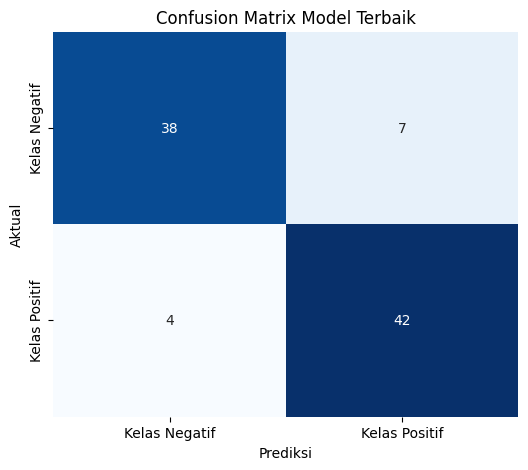

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=452, n_features=280, n_classes=2, random_state=42)

# Split 80:20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Hyperparameter grid
param_grid = [
    {"kernel": "linear", "C": 0.1},
    {"kernel": "linear", "C": 1},
    {"kernel": "linear", "C": 10},

    {"kernel": "rbf", "C": 0.1, "gamma": 0.1},
    {"kernel": "rbf", "C": 0.1, "gamma": 0.5},
    {"kernel": "rbf", "C": 0.1, "gamma": "scale"},

    {"kernel": "rbf", "C": 1, "gamma": 0.1},
    {"kernel": "rbf", "C": 1, "gamma": 0.5},
    {"kernel": "rbf", "C": 1, "gamma": "scale"},

    {"kernel": "rbf", "C": 10, "gamma": 0.1},
    {"kernel": "rbf", "C": 10, "gamma": 0.5},
    {"kernel": "rbf", "C": 10, "gamma": "scale"},
]

results = []
best_acc = -1
best_model = None
best_pred = None

# Loop semua percobaan
for i, params in enumerate(param_grid, start=1):
    clf = svm.SVC(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred, zero_division=0) * 100
    rec = recall_score(y_test, y_pred, zero_division=0) * 100
    f1 = f1_score(y_test, y_pred, zero_division=0) * 100

    results.append([
        i,
        params["kernel"],
        params["C"],
        params.get("gamma", "-"),
        f"{acc:.2f}%",
        f"{prec:.2f}%",
        f"{rec:.2f}%",
        f"{f1:.2f}%"
    ])

    # Simpan model terbaik
    if acc > best_acc:
        best_acc = acc
        best_model = clf
        best_pred = y_pred

# Simpan hasil ke DataFrame
columns = ["No", "Kernel", "Cost (C)", "Gamma", "Akurasi", "Precision", "Recall", "F1-score"]
df_results = pd.DataFrame(results, columns=columns)

# Print tabel hasil
print(df_results.to_string(index=False))

# Confusion matrix model terbaik
cm = confusion_matrix(y_test, best_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Kelas Negatif", "Kelas Positif"],
            yticklabels=["Kelas Negatif", "Kelas Positif"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix Model Terbaik")
plt.show()


 No Kernel  Cost (C) Gamma Akurasi Precision  Recall F1-score
  1 linear       0.1     -  74.26%    75.76%  72.46%   74.07%
  2 linear       1.0     -  74.26%    75.76%  72.46%   74.07%
  3 linear      10.0     -  74.26%    75.76%  72.46%   74.07%
  4    rbf       0.1   0.1  50.74%    50.74% 100.00%   67.32%
  5    rbf       0.1   0.5  50.74%    50.74% 100.00%   67.32%
  6    rbf       0.1 scale  50.74%    50.74% 100.00%   67.32%
  7    rbf       1.0   0.1  50.74%    50.74% 100.00%   67.32%
  8    rbf       1.0   0.5  50.74%    50.74% 100.00%   67.32%
  9    rbf       1.0 scale  84.56%    86.36%  82.61%   84.44%
 10    rbf      10.0   0.1  50.74%    50.74% 100.00%   67.32%
 11    rbf      10.0   0.5  50.74%    50.74% 100.00%   67.32%
 12    rbf      10.0 scale  83.82%    86.15%  81.16%   83.58%


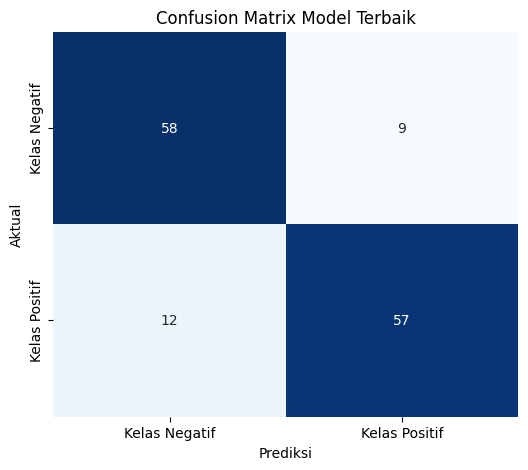

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=452, n_features=280, n_classes=2, random_state=42)

# Split 70:30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Hyperparameter grid
param_grid = [
    {"kernel": "linear", "C": 0.1},
    {"kernel": "linear", "C": 1},
    {"kernel": "linear", "C": 10},

    {"kernel": "rbf", "C": 0.1, "gamma": 0.1},
    {"kernel": "rbf", "C": 0.1, "gamma": 0.5},
    {"kernel": "rbf", "C": 0.1, "gamma": "scale"},

    {"kernel": "rbf", "C": 1, "gamma": 0.1},
    {"kernel": "rbf", "C": 1, "gamma": 0.5},
    {"kernel": "rbf", "C": 1, "gamma": "scale"},

    {"kernel": "rbf", "C": 10, "gamma": 0.1},
    {"kernel": "rbf", "C": 10, "gamma": 0.5},
    {"kernel": "rbf", "C": 10, "gamma": "scale"},
]

results = []
best_acc = -1
best_model = None
best_pred = None

# Loop semua percobaan
for i, params in enumerate(param_grid, start=1):
    clf = svm.SVC(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred, zero_division=0) * 100
    rec = recall_score(y_test, y_pred, zero_division=0) * 100
    f1 = f1_score(y_test, y_pred, zero_division=0) * 100

    results.append([
        i,
        params["kernel"],
        params["C"],
        params.get("gamma", "-"),
        f"{acc:.2f}%",
        f"{prec:.2f}%",
        f"{rec:.2f}%",
        f"{f1:.2f}%"
    ])

    # Simpan model terbaik
    if acc > best_acc:
        best_acc = acc
        best_model = clf
        best_pred = y_pred

# Simpan hasil ke DataFrame
columns = ["No", "Kernel", "Cost (C)", "Gamma", "Akurasi", "Precision", "Recall", "F1-score"]
df_results = pd.DataFrame(results, columns=columns)

# Print tabel hasil
print(df_results.to_string(index=False))

# Confusion matrix model terbaik
cm = confusion_matrix(y_test, best_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Kelas Negatif", "Kelas Positif"],
            yticklabels=["Kelas Negatif", "Kelas Positif"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix Model Terbaik")
plt.show()


/tmp/ipython-input-932737235.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = (df['diagnosis'] != 1).astype(int)



=== Hasil Evaluasi Semua Percobaan ===
 No Kernel  Cost (C) Gamma Akurasi Precision Recall F1-score
  1 linear       0.1     -  69.06%    65.17% 69.88%   67.44%
  2 linear       1.0     -  65.75%    61.80% 66.27%   63.95%
  3 linear      10.0     -  65.75%    61.80% 66.27%   63.95%
  4    rbf       0.1   0.1  54.14%     0.00%  0.00%    0.00%
  5    rbf       0.1   0.5  54.14%     0.00%  0.00%    0.00%
  6    rbf       0.1 scale  54.14%     0.00%  0.00%    0.00%
  7    rbf       1.0   0.1  54.14%     0.00%  0.00%    0.00%
  8    rbf       1.0   0.5  54.14%     0.00%  0.00%    0.00%
  9    rbf       1.0 scale  75.14%    91.30% 50.60%   65.12%
 10    rbf      10.0   0.1  54.14%     0.00%  0.00%    0.00%
 11    rbf      10.0   0.5  54.14%     0.00%  0.00%    0.00%
 12    rbf      10.0 scale  75.14%    79.69% 61.45%   69.39%


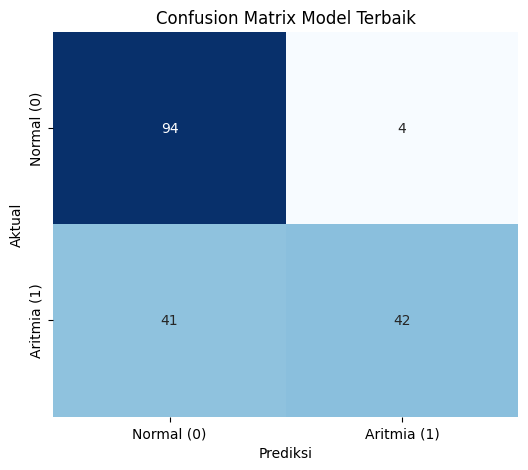


Model terbaik: SVC(C=1)
Akurasi terbaik: 75.14%


In [43]:
# ================================
# 🔸 Import Library
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# ================================
# 🔸 Load & Preprocessing Data
# ================================
df = pd.read_csv('/content/drive/MyDrive/Skripsi/Dataset/Penyakit_Jantung/data_aritmia.csv', sep=';')

# Ganti karakter aneh jadi NaN
df = df.replace(['?', ' ', ''], np.nan)

# Konversi kolom numerik
for col in df.columns:
    if col != 'diagnosis':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop kolom kosong total
na_all = df.columns[df.isna().all()]
df = df.drop(columns=na_all)

# Isi NaN dengan median
for col in df.columns:
    if col != 'diagnosis' and df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Target: diagnosis != 1 → 1 (aritmia), diagnosis = 1 → 0 (normal)
df['target'] = (df['diagnosis'] != 1).astype(int)

# Fitur dan label
X = df.drop(columns=['diagnosis', 'target'])
y = df['target']

# ================================
# 🔸 Split Data 60:40
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# ================================
# 🔸 Hyperparameter Grid SVM
# ================================
param_grid = [
    {"kernel": "linear", "C": 0.1},
    {"kernel": "linear", "C": 1},
    {"kernel": "linear", "C": 10},

    {"kernel": "rbf", "C": 0.1, "gamma": 0.1},
    {"kernel": "rbf", "C": 0.1, "gamma": 0.5},
    {"kernel": "rbf", "C": 0.1, "gamma": "scale"},

    {"kernel": "rbf", "C": 1, "gamma": 0.1},
    {"kernel": "rbf", "C": 1, "gamma": 0.5},
    {"kernel": "rbf", "C": 1, "gamma": "scale"},

    {"kernel": "rbf", "C": 10, "gamma": 0.1},
    {"kernel": "rbf", "C": 10, "gamma": 0.5},
    {"kernel": "rbf", "C": 10, "gamma": "scale"},
]

# ================================
# 🔸 Training & Evaluasi
# ================================
results = []
best_acc = -1
best_model = None
best_pred = None

for i, params in enumerate(param_grid, start=1):
    clf = svm.SVC(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred, zero_division=0) * 100
    rec = recall_score(y_test, y_pred, zero_division=0) * 100
    f1 = f1_score(y_test, y_pred, zero_division=0) * 100

    results.append([
        i,
        params["kernel"],
        params["C"],
        params.get("gamma", "-"),
        f"{acc:.2f}%",
        f"{prec:.2f}%",
        f"{rec:.2f}%",
        f"{f1:.2f}%"
    ])

    if acc > best_acc:
        best_acc = acc
        best_model = clf
        best_pred = y_pred

# ================================
# 🔸 Tabel Hasil
# ================================
columns = ["No", "Kernel", "Cost (C)", "Gamma", "Akurasi", "Precision", "Recall", "F1-score"]
df_results = pd.DataFrame(results, columns=columns)
print("\n=== Hasil Evaluasi Semua Percobaan ===")
print(df_results.to_string(index=False))

# ================================
# 🔸 Confusion Matrix Model Terbaik
# ================================
cm = confusion_matrix(y_test, best_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Normal (0)", "Aritmia (1)"],
            yticklabels=["Normal (0)", "Aritmia (1)"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix Model Terbaik")
plt.show()

print(f"\nModel terbaik: {best_model}")
print(f"Akurasi terbaik: {best_acc:.2f}%")
